In [1]:
import pandas as pd
import tsfresh
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.model_selection import train_test_split

In [9]:
df = pd.read_csv('../data/graded_data.csv')

In [10]:
target = pd.read_csv('last_attempt.csv')
target['id'] = target['Slide ID']+'_'+target['Well'].astype(str)

In [11]:
zoe = pd.read_excel('Zoe Final.xlsx')

In [12]:
zoe['id'] =  target['Slide ID']+'_'+target['Well'].astype(str)

In [14]:
columns = ['id', 'tPNf', 't2', 't3', 't4', 't5', 't6', 'Dynamic Score - Time',
          'Dynamic Score - Value' ,
           'Morphological Grade - Time', 
           'Grade at approx. 65h - Zoe',
          'Day3 Grade', 'Day3 Cells', 
           'Fragmentation - Time 1',
        'Fragmentation - Value 1',
           'Multi Nucleation - Time 1',
        'Multi Nucleation - Value 1',
          'Blastomere Size - Time 1',
        'Blastomere Size - Value 1',
           'Pronuclei - Time 1',
          'Pronuclei - Value 1']

In [13]:
graded_embryoscope = pd.merge(target, zoe[columns].drop_duplicates('id', keep='first'), on='id', how='left')

In [15]:
whole = pd.merge(df.drop_duplicates('id', keep='first'), graded_embryoscope, on='id', how='left')

In [16]:
extra_feats_cols = ['id', 'Morphological Grade - Value', 'tPNf', 't2', 't3', 't4', 't5', 't6',
       'Dynamic Score - Time', 
       'Morphological Grade - Time', 
      'Fragmentation - Time 1',
       'Fragmentation - Value 1', 'Multi Nucleation - Time 1',
       'Multi Nucleation - Value 1', 'Blastomere Size - Time 1',
       'Blastomere Size - Value 1', 'Pronuclei - Time 1',
       'Pronuclei - Value 1']

In [17]:
extra_feats = whole[extra_feats_cols].fillna(value=whole[extra_feats_cols].mean())

In [18]:
extra_feats['diff_65'] = extra_feats['t6'] - extra_feats['t5']
extra_feats['diff_64'] = extra_feats['t6'] - extra_feats['t4']
extra_feats['diff_63'] = extra_feats['t6'] - extra_feats['t3']
extra_feats['diff_62'] = extra_feats['t6'] - extra_feats['t2']
extra_feats['diff_61'] = extra_feats['t6'] - extra_feats['tPNf']

extra_feats['diff_54'] = extra_feats['t5'] - extra_feats['t4']
extra_feats['diff_53'] = extra_feats['t5'] - extra_feats['t3']
extra_feats['diff_52'] = extra_feats['t5'] - extra_feats['t2']
extra_feats['diff_51'] = extra_feats['t5'] - extra_feats['tPNf']


extra_feats['diff_43'] = extra_feats['t4'] - extra_feats['t3']
extra_feats['diff_42'] = extra_feats['t4'] - extra_feats['t2']
extra_feats['diff_41'] = extra_feats['t4'] - extra_feats['tPNf']

extra_feats['diff_32'] = extra_feats['t3'] - extra_feats['t2']
extra_feats['diff_31'] = extra_feats['t3'] - extra_feats['tPNf']

extra_feats['diff_21'] = extra_feats['t2'] - extra_feats['tPNf']

In [19]:
timesteps = pd.read_csv('grade_timesteps.csv')

In [20]:
timesteps['DT']=timesteps.groupby('id').diff()

In [21]:
timesteps = timesteps.groupby('id').DT.mean().reset_index()

In [22]:
test =  pd.merge(df, timesteps, 'inner', on='id')

In [23]:
test['Time'] = test.groupby('id').DT.cumsum()

In [24]:
id_enc = LabelEncoder()

In [25]:
df['id'] = id_enc.fit_transform(df['id'])

In [26]:
df = df.fillna(value=df.mean())

In [27]:
def drop_empty(x):
    area = x.area.values
    if area.min()>3000:
        return x
    
def get_small_t(x):
    if x.Time.iloc[-1]>3:
        return x

def drop_no_fert(x):
    if x.area.values[-1]>5500:
        return x

def drop_early(x):
    if x.Time.max()>4.65:
        return x

In [525]:
clean = test.groupby('id').apply(get_small_t).reset_index(drop=True)
clean = clean.groupby('id').apply(drop_empty).reset_index(drop=True)
clean = clean.groupby('id').apply(drop_early).reset_index(drop=True)

In [526]:
features_list = ['eccentricity','minor_axis_length', 'major_axis_length',
                 'area', 'solidity', 'Time',]

In [527]:
def resample_(x):
    period = '30min'
    new_df = pd.DataFrame()
    
    for c in x.columns:
        if c!='id':
            ts = x.loc[x['Time']<=3.51][c]

            ts.index = pd.DatetimeIndex(x.loc[x['Time']<=3.51]['Time']*8.64e+13)
            ts = ts.resample('30min').mean()
            new_df[c] = ts
        else:
            continue
    return new_df


resampled_df = clean[['id']+features_list].groupby('id').apply(resample_)

In [528]:
resampled_df['Time_1'] = resampled_df['Time']
del resampled_df['Time']

resampled_df = resampled_df.reset_index()
resampled_df['Time_1'] = resampled_df['Time_1']-0.01043

In [529]:
X_3 = resampled_df.groupby('id').apply(lambda x: x.loc[x.Time_1<=3]).reset_index(drop=True)
X_35 = resampled_df.groupby('id').apply(lambda x: x.loc[x.Time_1<=3.5]).reset_index(drop=True)

In [530]:
area_3 = X_3.groupby('id').apply(lambda x: x.area.iloc[-1])
area_35 = X_35.groupby('id').apply(lambda x: x.area.iloc[-1])

In [533]:
target_area = clean.groupby('id').apply(lambda x: x.loc[x.Time>4.].area.mean())
diff = target_area - area_3

In [535]:
X_3['area_diff'] = X_['area'].diff()
X_3 = X_3.fillna(0)

In [536]:
X_3['eccentricity_diff'] = X_3['eccentricity'].diff()
X_3 = X_3.fillna(0)

In [537]:
X_3['minor_axis_length_diff'] = X_3['minor_axis_length'].diff()
X_3 = X_3.fillna(0)

In [538]:
X_3['major_axis_length_diff'] = X_3['major_axis_length'].diff()
X_3 = X_3.fillna(0)

In [539]:
X_3['solidity_diff'] = X_3['solidity'].diff()
X_3 = X_3.fillna(0)

In [540]:
features_list = ['eccentricity','minor_axis_length', 'major_axis_length',
                 'area','area_diff', 'eccentricity_diff', 'solidity', 'Time_1',
                'major_axis_length_diff', 'eccentricity_diff', 'minor_axis_length_diff',
                'solidity_diff']

In [541]:
from tsfresh.feature_extraction import EfficientFCParameters, MinimalFCParameters
settings = EfficientFCParameters()
# Set here the options of the settings object as shown in the paragraphs below
from tsfresh.feature_extraction import extract_features
extracted_feats = extract_features(X_3[['id']+features_list].dropna(), default_fc_parameters=settings, column_id='id')

Feature Extraction: 100%|████████████| 140/140 [09:20<00:00,  4.00s/it]


In [542]:
extracted_feats_df = pd.DataFrame(extracted_feats)

In [543]:
extracted_feats_df = extracted_feats.copy().reset_index()

In [544]:
extracted_feats_pca_df = extracted_feats_df.copy()

In [545]:
whole = pd.merge(extracted_feats_pca_df, extra_feats, on='id')

In [546]:
whole['Morphological Grade - Value'] = whole['Morphological Grade - Value'].replace('ARREST', 4)
whole['Morphological Grade - Value'] = whole['Morphological Grade - Value'].replace('2,5', 2.5)
whole['Morphological Grade - Value'] = whole['Morphological Grade - Value'].replace('4CC', 3)
whole['Morphological Grade - Value'] = whole['Morphological Grade - Value'].replace('ARREST', 4)
whole['Morphological Grade - Value'] = whole['Morphological Grade - Value'].replace('2,5', 2.5)
whole['Morphological Grade - Value'] = whole['Morphological Grade - Value'].replace('3,5', 3.5)
whole['Morphological Grade - Value'] = whole['Morphological Grade - Value'].replace('4AA', 1)
whole['Morphological Grade - Value'] = whole['Morphological Grade - Value'].replace('EX1', 4)
whole['Morphological Grade - Value'] = whole['Morphological Grade - Value'].replace('1,5', 1.5)
whole['Morphological Grade - Value'] = whole['Morphological Grade - Value'].replace('8', 4)
whole['Morphological Grade - Value'] = whole['Morphological Grade - Value'].replace('1.2', 1)


whole['Morphological Grade - Value'] = whole['Morphological Grade - Value'].astype(float)
whole['Morphological Grade - Value'] = whole['Morphological Grade - Value'].replace(5, 4)

In [547]:
whole['Morphological Grade - Value'].value_counts()


2.0    673
2.5    491
1.5    372
3.0    290
1.0    189
3.5    116
4.0     39
Name: Morphological Grade - Value, dtype: int64

In [548]:
whole = whole.dropna(axis=1)

In [549]:
lbl_enc = LabelEncoder()

In [550]:
whole['id'] = lbl_enc.fit_transform(whole['id'].values[:,None])

C:\Users\hp\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [551]:
X = whole.dropna(axis=1)

In [552]:
X.dropna(axis=0)

,id,Time_1__abs_energy,Time_1__absolute_sum_of_changes,"Time_1__agg_autocorrelation__f_agg_""mean""__maxlag_40","Time_1__agg_autocorrelation__f_agg_""median""__maxlag_40","Time_1__agg_autocorrelation__f_agg_""var""__maxlag_40","Time_1__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""max""","Time_1__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""mean""","Time_1__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""min""","Time_1__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""var""",...,diff_54,diff_53,diff_52,diff_51,diff_43,diff_42,diff_41,diff_32,diff_31,diff_21
0,0,436.333952,2.999241,0.664593,0.677094,0.041784,0.197996,0.098346,-0.000647,0.003887,...,-7.622750,-0.288166,12.714019,16.051122,7.334585,20.336769,23.673873,13.002184,16.339288,3.337104
1,1,436.329832,2.999124,0.664635,0.677134,0.041774,0.197988,0.098336,-0.000648,0.003887,...,9.900518,11.630165,21.392493,24.623815,1.729647,11.491976,14.723297,9.762328,12.993650,3.231321
2,2,436.330526,2.999126,0.664635,0.677134,0.041774,0.197988,0.098336,-0.000648,0.003887,...,14.026713,16.354329,30.682190,32.639721,2.327616,16.655477,18.613008,14.327861,16.285392,1.957531
3,3,436.347588,2.999185,0.664635,0.677134,0.041774,0.197992,0.098338,-0.000648,0.003887,...,9.900518,11.630165,21.392493,24.623815,1.729647,11.491976,14.723297,9.762328,12.993650,3.231321
4,4,436.347933,2.999186,0.664635,0.677134,0.041774,0.197992,0.098338,-0.000648,0.003887,...,3.334188,3.334188,14.336666,16.997362,0.000000,11.002478,13.663174,11.002478,13.663174,2.660696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2165,2165,434.524361,2.995757,0.664610,0.677263,0.041855,0.193629,0.094330,-0.003961,0.003854,...,9.900518,11.630165,21.392493,24.623815,1.729647,11.491976,14.723297,9.762328,12.993650,3.231321
2166,2166,434.544344,2.995826,0.664610,0.677263,0.041855,0.193633,0.094333,-0.003961,0.003854,...,16.330660,17.673914,29.003620,36.467566,1.343253,12.672959,20.136905,11.329706,18.793652,7.463946
2167,2167,434.545014,2.995828,0.664610,0.677263,0.041855,0.193634,0.094333,-0.003961,0.003854,...,17.075098,17.075098,27.432342,31.173044,0.000000,10.357244,14.097946,10.357244,14.097946,3.740702
2168,2168,434.553584,2.995857,0.664610,0.677263,0.041855,0.193636,0.094334,-0.003961,0.003854,...,15.670112,16.003515,27.673169,30.327652,0.333403,12.003057,14.657540,11.669654,14.324137,2.654483


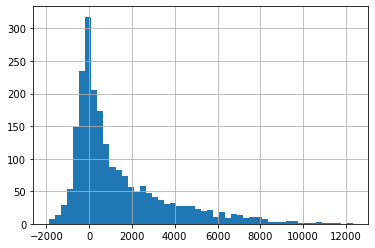

In [553]:
diff.hist(bins=50)

In [593]:
metric = pd.DataFrame()

In [594]:
metric['metric'] = (np.log((diff-diff.min()+0.01).values/X['Morphological Grade - Value']))

In [595]:
metric

,metric
0,7.437796
1,6.663441
2,6.797995
3,8.153150
4,6.608067
...,...
2165,6.543521
2166,6.866209
2167,7.081122
2168,7.082026


In [596]:
metric['id'] = diff.index

In [597]:
metric.index = metric['id']

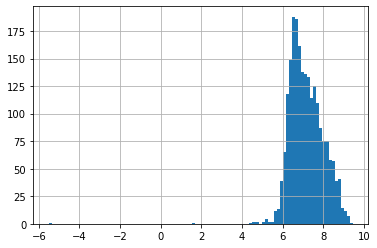

In [604]:
metric['metric'].hist(bins=100)

In [560]:
y_class = metric.copy()
y_class.loc[metric['metric']>=8] = 'Great'
y_class.loc[(metric['metric']<8)&(metric['metric']>=5)] = 'Good'
y_class.loc[(metric['metric']<5)&(metric['metric']>=3.5)] = 'OK'
y_class.loc[(metric['metric']<3.5)] = 'Crap'

In [605]:
y_class = metric.copy()
y_class.loc[metric['metric']>=8.5] = 'Great'
y_class.loc[(metric['metric']<8.5)&(metric['metric']>=7.5)] = 'Good'
y_class.loc[(metric['metric']<7.5)&(metric['metric']>=6.)] = 'OK'
y_class.loc[(metric['metric']<6.)] = 'Crap'

In [607]:
y_class['metric'].value_counts()

OK       1386
Good      575
Great     131
Crap       78
Name: metric, dtype: int64

In [582]:
y_class['grade'] = X['Morphological Grade - Value'].values

In [583]:
y_class['grade']

id
D2016.01.05_S1181_I149_10       2.0
D2016.01.05_S1181_I149_3        2.5
D2016.01.05_S1181_I149_5        2.5
D2016.01.05_S1181_I149_6        2.0
D2016.01.05_S1181_I149_7        2.5
                               ... 
D2019.05.29_S02006_I0149_D_2    1.5
D2019.05.29_S02006_I0149_D_4    2.0
D2019.05.29_S02006_I0149_D_5    2.5
D2019.05.29_S02006_I0149_D_7    2.0
D2019.05.29_S02006_I0149_D_8    2.5
Name: grade, Length: 2170, dtype: float64

In [584]:
y_class.groupby('metric').grade.apply(lambda x: x.value_counts())

metric     
Crap    2.5    454
        3.0    290
        3.5    116
        4.0     39
        2.0     30
        1.5      1
Good    1.5    298
        1.0     79
Great   1.0    110
OK      2.0    643
        1.5     73
        2.5     37
Name: grade, dtype: int64

In [608]:
y_class = y_class.fillna(value='OK')

In [609]:
y_enc = y_class['metric'].values

In [564]:
train_idx = lbl_enc.transform(np.load('train_ids.npy',allow_pickle=True))
test_idx = lbl_enc.transform(np.load('test_ids.npy',allow_pickle=True))

In [565]:
from lightgbm import LGBMRegressor, LGBMClassifier, plot_importance
import lightgbm as lgb
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score

In [566]:
#del X['id']

In [567]:
from sklearn.model_selection import train_test_split, KFold
Nfolds = 10
kfold = KFold(Nfolds)

In [568]:
lgb_params = {'verbose': 100, 'objective': 'multiclass', 'num_rounds':1000 ,
          'num_class':4}

In [569]:
X_no_grade = X.drop('Morphological Grade - Value',axis=1)

In [611]:
for train_idx, valid_idx in kfold.split(X, y_enc):
    X_train, X_test = X_no_grade.iloc[train_idx,:200].values, X_no_grade.iloc[test_idx,:200].values

    y_train, y_test = y_enc[train_idx], y_enc[test_idx]

    lgb_train = lgb.Dataset(X_train, y_train, params={'verbose': -1}, free_raw_data=False)
    lgb_eval = lgb.Dataset(X_test, y_test, params={'verbose': -1},free_raw_data=False)
    clf = LGBMClassifier()
    clf.fit(X_train,y_train)
    preds = clf.predict(X_test)
    print('accuracy: ', accuracy_score(preds, y_test))

accuracy:  0.901840490797546
accuracy:  0.9171779141104295
accuracy:  0.8834355828220859
accuracy:  0.8865030674846626
accuracy:  0.901840490797546
accuracy:  0.8865030674846626
accuracy:  0.8895705521472392
accuracy:  0.8926380368098159
accuracy:  0.8803680981595092
accuracy:  0.8834355828220859


In [612]:
confusion_matrix(preds, y_test)

array([[ 10,   0,   0,   0],
       [  0,  58,   0,   8],
       [  0,   0,  15,   0],
       [  1,  27,   2, 205]], dtype=int64)

In [571]:
diff = diff.fillna(value=diff.mean())

In [572]:
for train_idx, valid_idx in kfold.split(X, diff):
    X_train, X_test = X_no_grade.iloc[train_idx,:900].values, X_no_grade.iloc[test_idx,:900].values

    y_train, y_test = diff[train_idx], diff[test_idx]

    lgb_train = lgb.Dataset(X_train, y_train, params={'verbose': -1}, free_raw_data=False)
    lgb_eval = lgb.Dataset(X_test, y_test, params={'verbose': -1},free_raw_data=False)
    clf = LGBMRegressor()
    clf.fit(X_train,y_train)
    preds = clf.predict(X_test)
    print('accuracy: ', r2_score(preds, y_test))
    

accuracy:  0.8655970628658186
accuracy:  0.8455064710135328
accuracy:  0.7619951588559519
accuracy:  0.8351162027152501
accuracy:  0.7107917220159273
accuracy:  0.9072698997326385
accuracy:  0.8670395823420177
accuracy:  0.8172546889432282
accuracy:  0.8360264274082734
accuracy:  0.8673957508478476


In [374]:
X[['Morphological Grade - Value']].iloc[folds[0],:]

,Morphological Grade - Value
442,2.0
443,2.5
444,2.0
445,3.5
446,2.0
...,...
2201,1.5
2202,2.0
2203,2.5
2204,2.0


In [375]:
X[['Morphological Grade - Value']].iloc[folds[1],:]

,Morphological Grade - Value
0,2.0
1,2.5
2,2.5
3,2.0
4,2.5
...,...
2201,1.5
2202,2.0
2203,2.5
2204,2.0


In [219]:
confusion_matrix(preds, y_test)

array([[137,   0,   0,   3],
       [  0,  63,   0,   0],
       [  0,   0,  23,   0],
       [  0,   0,   0, 100]], dtype=int64)

In [169]:
np.argsort(clf.feature_importances_)[-150:]

array([2606, 1610, 2024,   88, 5770, 3050, 5902, 4367, 7072, 6206, 5977,
       2609, 4299, 5706, 6844, 5337, 2872, 5321,   86, 5257, 3588, 6690,
       2180,  914, 2271, 6333, 6544, 2891, 2618, 3579, 1232, 2352, 4460,
       4485, 4507, 3992, 2550, 2613, 5840, 1144, 5425, 3220, 6406, 4771,
       1712, 4533,  906, 1778, 6094, 6803, 1432, 3942, 5218, 5230, 2577,
       3750, 5104, 6491, 5844, 4840, 3348, 3054, 7318, 4572,  233, 3900,
       6120, 5974, 7521, 5018, 6049, 3694, 6026,    0, 3924,  785, 2843,
       2147, 6208, 2296, 1882, 1782, 4261, 6350,  903, 4149, 5217, 3419,
       3543, 1895, 7018, 1011, 7529, 3791, 1139, 4788,  329, 3101, 7687,
       2717,  799, 7334, 4300, 2890, 6362, 3756, 4469, 6813, 6507, 5847,
       5204, 4624, 6419, 1123, 4099, 1780, 7500, 2875, 2626, 1902, 5025,
       5312, 7017, 6888, 6415, 6357, 3927,  509, 1968, 4813, 3293, 2999,
       5271, 7519, 7425, 3420, 6361, 5914, 5766, 5921, 1817,  642, 4091,
       6479, 1611, 2361, 4453, 1005, 4814, 7722], d

In [181]:
for c in X.iloc[train_idx,np.argsort(clf.feature_importances_)[-150:]].columns:
    print(c)

Time_1__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"min"
Time_1__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6
Time_1__autocorrelation__lag_0
Time_1__autocorrelation__lag_9
Time_1__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max"
Time_1__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"
Time_1__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean"
Time_1__c3__lag_1
Time_1__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean"
Time_1__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"min"
Time_1__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"min"
Time_1__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min"
Time_1__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2
Time_1__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6
Time_1__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4
Time_1__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"
Time_1__ar_coefficient__coeff_9__k_10
Time_1__chang